In [4]:
# -*- coding: utf-8 -*-
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import logging

In [5]:
def find_and_plot_points(results_dir, pattern):
    """
    Busca archivos CSV que coincidan con el patrón en subdirectorios,
    los agrupa por el valor 'N' extraído del nombre, cuenta cuántos hay por N,
    y genera un gráfico K vs S para cada N.

    Args:
        results_dir (str): Ruta al directorio principal 'results'.
        pattern (str): Patrón regex para buscar archivos y extraer N.
                       Debe tener dos grupos de captura: el primero para el nombre base
                       y el segundo para el número N.
    """
    # Compilar el regex para eficiencia
    try:
        regex = re.compile(pattern)
    except re.error as e:
        logging.error(f"Error al compilar el patrón regex '{pattern}': {e}")
        return

    # Diccionario para almacenar las rutas de los archivos agrupadas por N
    # defaultdict(list) crea una lista vacía automáticamente si la clave N no existe
    files_by_n = defaultdict(list)

    # --- 1. Escanear directorios y encontrar archivos ---
    logging.info(f"Buscando archivos en '{results_dir}' con el patrón '{pattern}'...")
    if not os.path.isdir(results_dir):
        logging.error(f"El directorio '{results_dir}' no existe o no es un directorio.")
        return

    found_files_count = 0
    # os.walk recorre el directorio y todos sus subdirectorios
    for root, dirs, files in os.walk(results_dir):
        for filename in files:
            match = regex.match(filename)
            if match:
                try:
                    # Extraer el valor de N (segundo grupo de captura)
                    n_value = int(match.group(2))
                    # Construir la ruta completa al archivo
                    file_path = os.path.join(root, filename)
                    # Añadir la ruta a la lista correspondiente a su valor N
                    files_by_n[n_value].append(file_path)
                    found_files_count += 1
                    # logging.debug(f"Encontrado: {file_path} (N={n_value})") # Descomentar para debug detallado
                except ValueError:
                    logging.warning(f"No se pudo convertir el valor N a entero en el archivo: {filename}")
                except IndexError:
                     logging.warning(f"El patrón regex no capturó el grupo N correctamente en: {filename}")


    if not files_by_n:
        logging.warning("No se encontraron archivos que coincidan con el patrón.")
        return

    logging.info(f"Se encontraron {found_files_count} archivos en total.")

    # --- 2. Contar y mostrar cuántos archivos hay por cada N ---
    logging.info("Conteo de archivos por valor de N:")
    # Ordenar por N para una salida más clara
    sorted_n_values = sorted(files_by_n.keys())
    for n_value in sorted_n_values:
        count = len(files_by_n[n_value])
        logging.info(f"  N = {n_value}: {count} archivo(s)")

    # --- 3. Leer datos y generar gráficos ---
    logging.info("Generando gráficos K vs S para cada valor de N...")

    fig, ax = plt.subplots(figsize=(10, 6)) # Tamaño del gráfico
    for n_value in sorted_n_values:
        if n_value > 12:
            continue
        logging.info(f"Procesando N = {n_value}...")
        # Crear una nueva figura y ejes para cada N

        file_list = files_by_n[n_value]
        plot_successful_count = 0

        for file_path in file_list:
            try:
                # Leer el archivo CSV usando pandas
                df = pd.read_csv(file_path, delimiter="\t")

                # Verificar que las columnas 'S' y 'K' existen
                if 'Point_X' not in df.columns or 'Point_Y' not in df.columns:
                    logging.warning(f"El archivo '{file_path}' no contiene las columnas Y_Points y/o X_Points. Saltando.")
                    continue # Pasar al siguiente archivo

                # Extraer las columnas S y K
                s_data = df['Point_X']
                k_data = df['Point_Y']

                # Graficar K vs S para este archivo en los ejes actuales
                # Usar alpha para transparencia si hay muchas líneas superpuestas
                ax.plot(s_data, k_data, linestyle='-', alpha=0.7, label=f"{n_value} Ptos. Promediado")
                plot_successful_count += 1

            except pd.errors.EmptyDataError:
                logging.warning(f"El archivo CSV '{file_path}' está vacío. Saltando.")
            except pd.errors.ParserError:
                 logging.warning(f"Error al parsear el archivo CSV '{file_path}'. Puede estar corrupto. Saltando.")
            except Exception as e:
                logging.error(f"Error inesperado al procesar el archivo '{file_path}': {e}")

        # Configurar el gráfico para el N actual
        if plot_successful_count > 0: # Solo mostrar gráfico si se pudo plotear algo
            ax.set_title(f'Curvatura (K) vs Longitud de Arco (S) para N = {n_value}')
            ax.set_xlabel('Coordenada X')
            ax.set_ylabel('Coordenada Y')
            ax.grid(True) # Añadir rejilla para facilitar la lectura

            # Añadir leyenda (puede ser grande si hay muchos archivos)
            # Considerar mostrarla solo si hay pocos archivos o ajustar su posición
            if len(file_list) <= 10: # Mostrar leyenda solo si no hay demasiados archivos
                 ax.legend(fontsize='small')
            else:
                 logging.info(f"  (Leyenda omitida para N={n_value} debido a demasiados archivos: {len(file_list)})")


            # Ajustar el layout para evitar solapamientos de etiquetas
            plt.tight_layout()
            plt.xlim(0, None)
            # Mostrar el gráfico (se mostrarán uno tras otro)
            # plt.show()
        else:
            logging.warning(f"No se pudieron graficar datos para N = {n_value}.")
            plt.close(fig) # Cerrar la figura vacía


In [6]:
def find_and_plot_cesaro_data(results_dir, pattern):
    """
    Busca archivos CSV que coincidan con el patrón en subdirectorios,
    los agrupa por el valor 'N' extraído del nombre, cuenta cuántos hay por N,
    y genera un gráfico K vs S para cada N.

    Args:
        results_dir (str): Ruta al directorio principal 'results'.
        pattern (str): Patrón regex para buscar archivos y extraer N.
                       Debe tener dos grupos de captura: el primero para el nombre base
                       y el segundo para el número N.
    """
    # Compilar el regex para eficiencia
    try:
        regex = re.compile(pattern)
    except re.error as e:
        logging.error(f"Error al compilar el patrón regex '{pattern}': {e}")
        return

    # Diccionario para almacenar las rutas de los archivos agrupadas por N
    # defaultdict(list) crea una lista vacía automáticamente si la clave N no existe
    files_by_n = defaultdict(list)

    # --- 1. Escanear directorios y encontrar archivos ---
    logging.info(f"Buscando archivos en '{results_dir}' con el patrón '{pattern}'...")
    if not os.path.isdir(results_dir):
        logging.error(f"El directorio '{results_dir}' no existe o no es un directorio.")
        return

    found_files_count = 0
    # os.walk recorre el directorio y todos sus subdirectorios
    for root, dirs, files in os.walk(results_dir):
        for filename in files:
            match = regex.match(filename)
            if match:
                try:
                    # Extraer el valor de N (segundo grupo de captura)
                    n_value = int(match.group(2))
                    # Construir la ruta completa al archivo
                    file_path = os.path.join(root, filename)
                    # Añadir la ruta a la lista correspondiente a su valor N
                    files_by_n[n_value].append(file_path)
                    found_files_count += 1
                    # logging.debug(f"Encontrado: {file_path} (N={n_value})") # Descomentar para debug detallado
                except ValueError:
                    logging.warning(f"No se pudo convertir el valor N a entero en el archivo: {filename}")
                except IndexError:
                     logging.warning(f"El patrón regex no capturó el grupo N correctamente en: {filename}")


    if not files_by_n:
        logging.warning("No se encontraron archivos que coincidan con el patrón.")
        return

    logging.info(f"Se encontraron {found_files_count} archivos en total.")

    # --- 2. Contar y mostrar cuántos archivos hay por cada N ---
    logging.info("Conteo de archivos por valor de N:")
    # Ordenar por N para una salida más clara
    sorted_n_values = sorted(files_by_n.keys())
    for n_value in sorted_n_values:
        count = len(files_by_n[n_value])
        logging.info(f"  N = {n_value}: {count} archivo(s)")

    # --- 3. Leer datos y generar gráficos ---
    logging.info("Generando gráficos K vs S para cada valor de N...")
    cols = ["Curvatura", "Angulo_Theta_rad"]
    for colY in cols:
        fig, ax = plt.subplots(figsize=(10, 6)) # Tamaño del gráfico
        for n_value in sorted_n_values:
            logging.info(f"Procesando N = {n_value}...")
            # Crear una nueva figura y ejes para cada N
    
            file_list = files_by_n[n_value]
            plot_successful_count = 0
    
            for file_path in file_list:
                try:
                    # Leer el archivo CSV usando pandas
                    df = pd.read_csv(file_path, delimiter="\t")
    
                    # Verificar que las columnas 'S' y 'K' existen
                    if 'LongitudArco_S' not in df.columns or colY not in df.columns:
                        logging.warning(f"El archivo '{file_path}' no contiene las columnas 'S' y/o 'K'. Saltando.")
                        continue # Pasar al siguiente archivo
    
                    # Extraer las columnas S y K
                    s_data = df['LongitudArco_S']
                    k_data = df[colY]
    
                    # Graficar K vs S para este archivo en los ejes actuales
                    # Usar alpha para transparencia si hay muchas líneas superpuestas
                    ax.plot(s_data, k_data, marker='.', linestyle='-', alpha=0.7, label=f"{n_value} Ptos. Promediado")
                    plot_successful_count += 1
    
                except pd.errors.EmptyDataError:
                    logging.warning(f"El archivo CSV '{file_path}' está vacío. Saltando.")
                except pd.errors.ParserError:
                     logging.warning(f"Error al parsear el archivo CSV '{file_path}'. Puede estar corrupto. Saltando.")
                except Exception as e:
                    logging.error(f"Error inesperado al procesar el archivo '{file_path}': {e}")
    
            # Configurar el gráfico para el N actual
            if plot_successful_count > 0: # Solo mostrar gráfico si se pudo plotear algo
                ax.set_title(f'Curvatura (K) vs Longitud de Arco (S) para N = {n_value}')
                ax.set_xlabel('Longitud de Arco (S)')
                ax.set_ylabel(colY)
                ax.grid(True) # Añadir rejilla para facilitar la lectura
    
                # Añadir leyenda (puede ser grande si hay muchos archivos)
                # Considerar mostrarla solo si hay pocos archivos o ajustar su posición
                if len(file_list) <= 10: # Mostrar leyenda solo si no hay demasiados archivos
                     ax.legend(fontsize='small')
                else:
                     logging.info(f"  (Leyenda omitida para N={n_value} debido a demasiados archivos: {len(file_list)})")
    
    
                # Ajustar el layout para evitar solapamientos de etiquetas
                plt.tight_layout()
                # Mostrar el gráfico (se mostrarán uno tras otro)
                # plt.show()
            else:
                logging.warning(f"No se pudieron graficar datos para N = {n_value}.")
                plt.close(fig) # Cerrar la figura vacía

    logging.info("Proceso completado.")

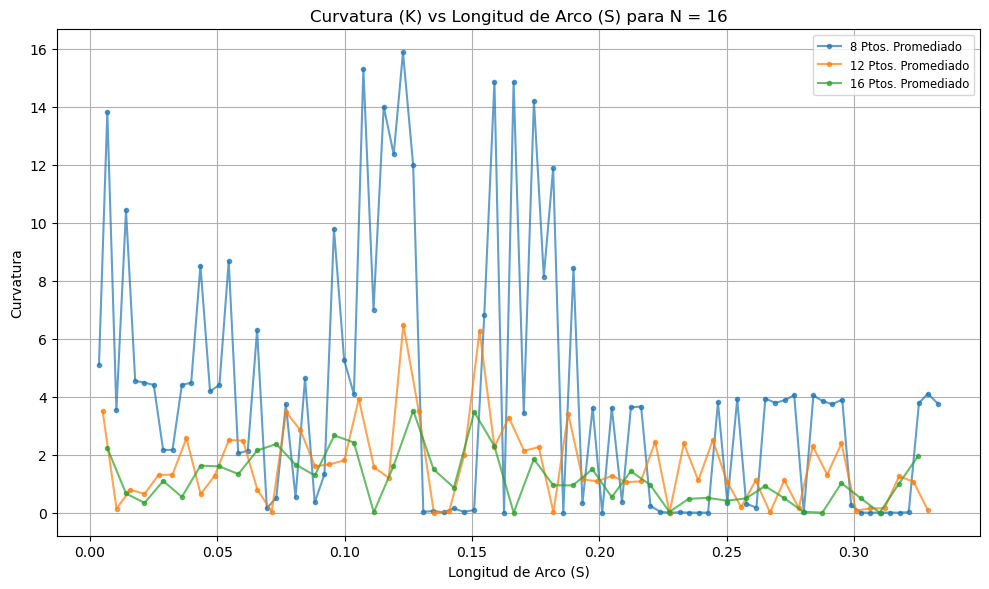

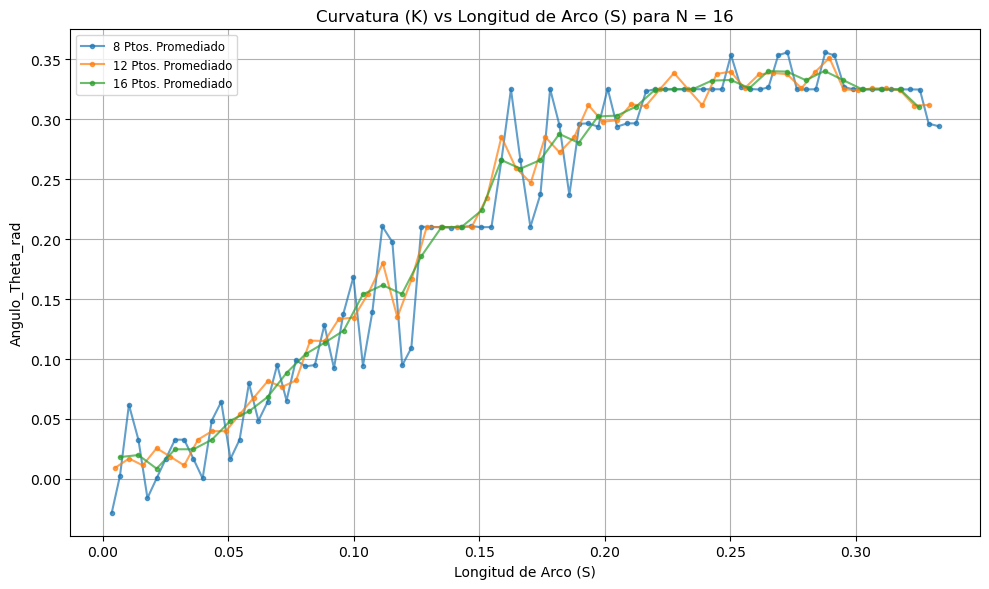

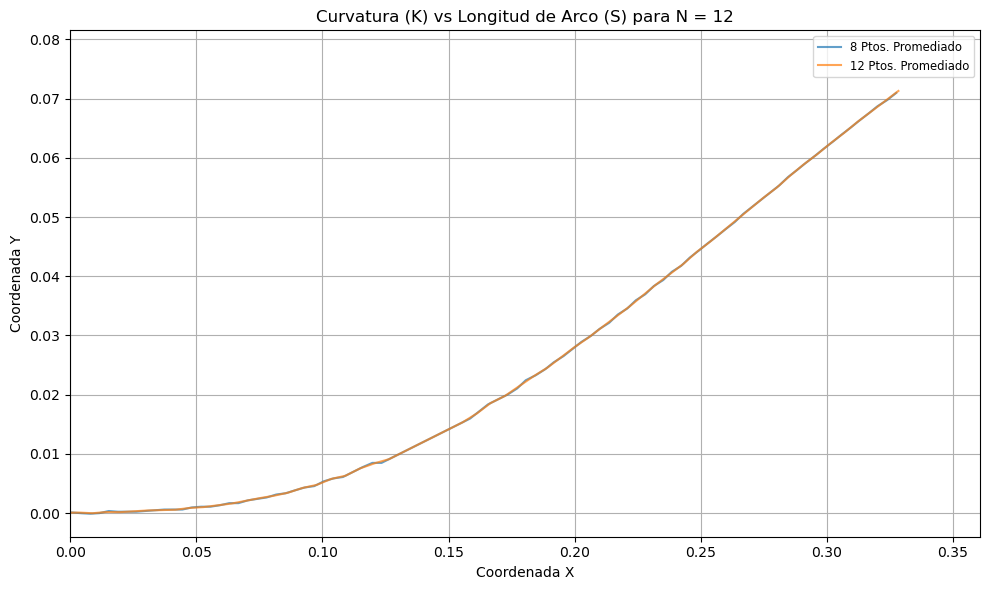

In [7]:
# --- Configuración ---
RESULTS_DIR = './results/20250428_h15_q2' # Directorio principal que contiene las carpetas de casos
FILENAME_PATTERN = r'^(.*)_avg(\d+)_Curvatura\.csv$' # Patrón regex para los nombres de archivo

# Llamar a la función principal
find_and_plot_cesaro_data(RESULTS_DIR, FILENAME_PATTERN)

FILENAME_PATTERN = r'^(.*)_avg(\d+)_Points\.csv$' # Patrón regex para los nombres de archiv

find_and_plot_points(RESULTS_DIR, FILENAME_PATTERN)

Text(0.5, 0, 'Coordenada X')

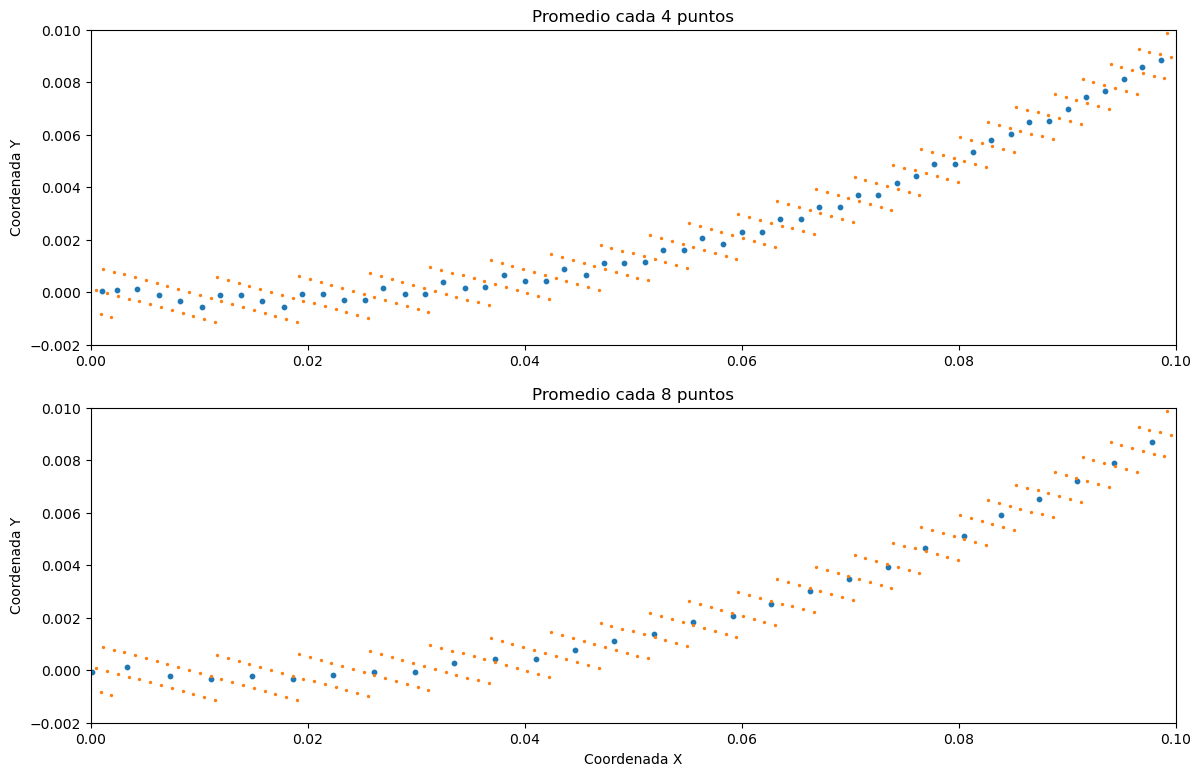

In [128]:
fig, axs = plt.subplots(2, 1, figsize=(14, 9)) # Tamaño del gráfico

for i, n in zip([0, 1], [4, 8]):
    data = np.loadtxt(f"results/20250427_q1/20250427_q1_ordered_avg{n}_Points.csv", skiprows=1, delimiter="\t")
    xs, ys = data[:, 0], data[:, 1]
    
    axs[i].scatter(xs, ys, s=10)
    axs[i].set_title(f"Promedio cada {n} puntos")

data = np.loadtxt("results/20250427_q1/20250427_q1.csv", skiprows=1, delimiter=",")
xs, ys = data[:, 0], data[:, 1]

for ax in axs.flatten():
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.002, 0.01)
    ax.scatter(xs, ys, s=2)
    ax.set_ylabel("Coordenada Y")
    
axs[1].set_xlabel("Coordenada X")


Text(0.5, 0, 'Coordenada X')

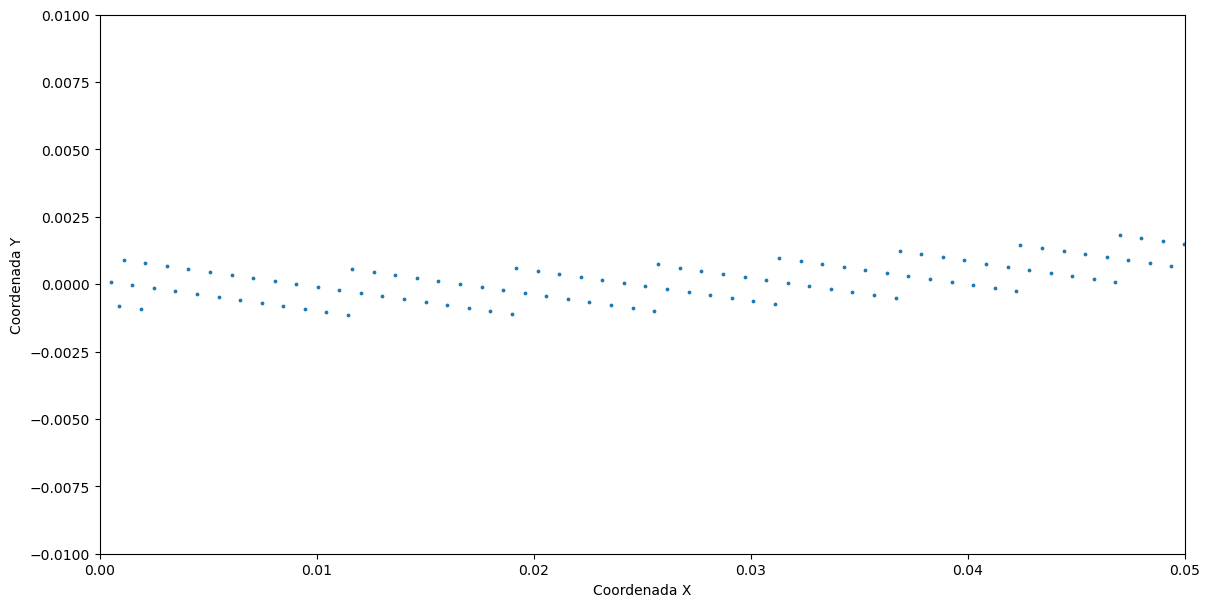

In [148]:

fig, axs = plt.subplots(1, 1, figsize=(14, 7)) # Tamaño del gráfico

data = np.loadtxt("results/20250427_q1/20250427_q1.csv", skiprows=1, delimiter=",")
xs, ys = data[:, 0], data[:, 1]

axs.set_xlim(0.0, 0.05)
axs.set_ylim(-0.01, 0.01)
axs.scatter(xs, ys, s=3)
axs.set_ylabel("Coordenada Y")
    
axs.set_xlabel("Coordenada X")

# Ajuste por parabola

- Seleccionar caso
- Ajustar por una parabola
- Ver el resultado
- Promediar los resultados a 12 puntos
- Hacer ecs intrinsecas de esos 2 casos
- Ajuste parabola y puntos promediados

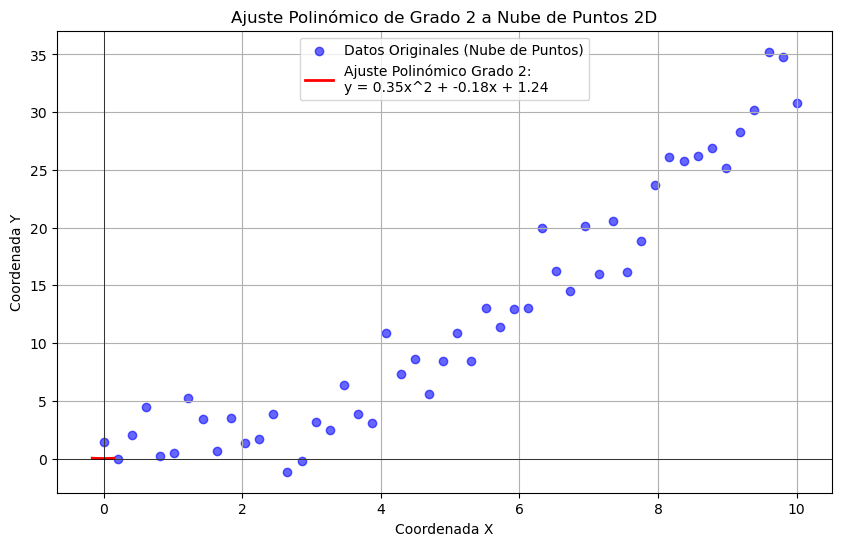

Coeficientes del polinomio ajustado (grado 2): a, b, c
a = 0.3535
b = -0.1804
c = 1.2352


In [154]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Obtener datos ----

data = np.loadtxt(, delimiter="\t", skiprows=1)
x_curva = data[:, 0]
y_curva = data[:, 1]

# --- 2. Realizar el ajuste polinómico de grado 2 ---
# polyfit devuelve los coeficientes del polinomio [a, b, c] para ax^2 + bx + c
coeficientes = np.polyfit(x_datos, y_datos, 2)

# Creamos una función polinómica a partir de los coeficientes
polinomio_ajustado = np.poly1d(coeficientes)

# --- 3. Preparar datos para graficar la curva ajustada ---
# Generamos puntos x para la curva ajustada (más densos para una curva suave)
#x_curva = np.linspace(min(x_datos), max(x_datos), 200)
#y_curva = polinomio_ajustado(x_curva)

# --- 4. Graficar los datos originales y la curva ajustada ---
plt.figure(figsize=(10, 6))

# Graficar los puntos originales
plt.scatter(x_datos, y_datos, label='Datos Originales (Nube de Puntos)', color='blue', alpha=0.6)

# Graficar la curva polinómica ajustada
plt.plot(x_curva, y_curva, label=f'Ajuste Polinómico Grado 2:\ny = {coeficientes[0]:.2f}x^2 + {coeficientes[1]:.2f}x + {coeficientes[2]:.2f}', color='red', linewidth=2)

# Añadir títulos y etiquetas
plt.title('Ajuste Polinómico de Grado 2 a Nube de Puntos 2D')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Mostrar el gráfico
plt.show()

# Imprimir los coeficientes del polinomio ajustado
print(f"Coeficientes del polinomio ajustado (grado 2): a, b, c")
print(f"a = {coeficientes[0]:.4f}")
print(f"b = {coeficientes[1]:.4f}")
print(f"c = {coeficientes[2]:.4f}")

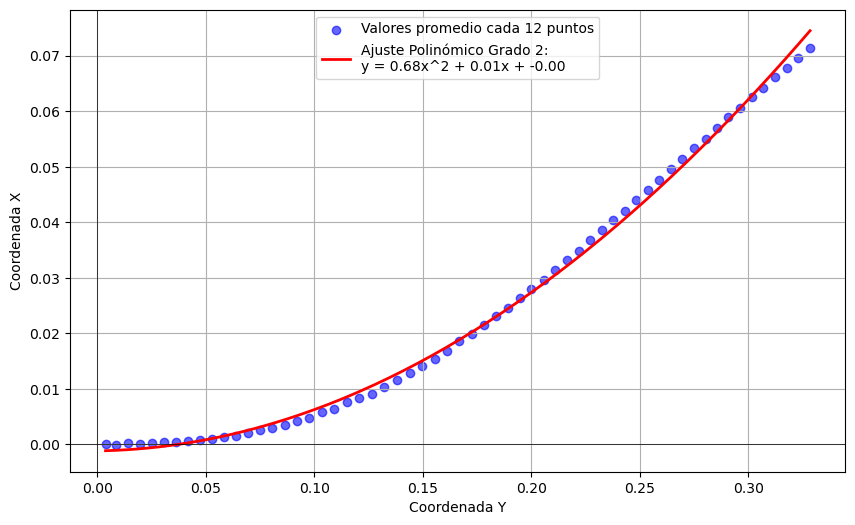

Coeficientes del polinomio ajustado (grado 2) para datos con x >= 0: a, b, c
a = 0.6832
b = 0.0060
c = -0.0012


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos CSV

# --- 1. Configuración del archivo de entrada ---
base_name = "./results/20250428_h15_q2/20250428_h15_q2_ordered_avg12_Points"
nombre_archivo_csv = base_name + ".csv" # Asegúrate de que este archivo exista y tenga el formato correcto
columna_x = 'Point_X' # Nombre de la columna para las coordenadas X en el CSV
columna_y = 'Point_Y' # Nombre de la columna para las coordenadas Y en el CSV

# --- 2. Leer y filtrar datos desde el archivo CSV ---
try:
    # Leer el archivo CSV usando pandas
    df_original = pd.read_csv(nombre_archivo_csv, delimiter="\t")

    # Verificar si las columnas existen
    if columna_x not in df_original.columns or columna_y not in df_original.columns:
        print(f"Error: Las columnas '{columna_x}' o '{columna_y}' no se encontraron en el archivo {nombre_archivo_csv}.")
        exit()

    # Filtrar los datos para mantener solo aquellos con x >= 0
    df_filtrado = df_original[df_original[columna_x] >= 0].copy() # .copy() para evitar SettingWithCopyWarning

    # Convertir las columnas filtradas a arrays de NumPy
    x_datos = df_filtrado[columna_x].values
    y_datos = df_filtrado[columna_y].values

    if len(x_datos) < 3: # Se necesitan al menos 3 puntos para un ajuste cuadrático significativo
        print("No hay suficientes datos con x >= 0 para realizar el ajuste polinómico (se necesitan al menos 3 puntos).")
        exit()

except FileNotFoundError:
    print(f"Error: El archivo '{nombre_archivo_csv}' no fue encontrado.")
    exit()
except Exception as e:
    print(f"Ocurrió un error al leer o procesar el archivo CSV: {e}")
    exit()

# --- 3. Realizar el ajuste polinómico de grado 2 ---
# polyfit devuelve los coeficientes del polinomio [a, b, c] para ax^2 + bx + c
# Se realiza sobre los datos ya filtrados
coeficientes = np.polyfit(x_datos, y_datos, 2)

# Creamos una función polinómica a partir de los coeficientes
polinomio_ajustado = np.poly1d(coeficientes)

# --- 4. Preparar datos para graficar la curva ajustada ---
# Generamos puntos x para la curva ajustada (más densos para una curva suave)
# Usamos el rango de los datos x filtrados
if len(x_datos) > 0:
    x_curva = np.linspace(min(x_datos), max(x_datos), 200)
    y_curva = polinomio_ajustado(x_curva)
else: # No debería llegar aquí por el check anterior, pero por si acaso
    x_curva = np.array([])
    y_curva = np.array([])

order_suffix = "ordered"
output_points = f"{base_name}_interpolated.csv"
np.savetxt(output_points, np.vstack((x_curva, y_curva)).T, fmt='%.6e', delimiter='\t',
                   header='Point_X\tPoint_Y', comments='')

# --- 5. Graficar los datos originales (filtrados) y la curva ajustada ---
plt.figure(figsize=(10, 6))

# Graficar los puntos originales (solo los que tienen x >= 0)
plt.scatter(x_datos, y_datos, label='Valores promedio cada 12 puntos', color='blue', alpha=0.6)

# Graficar la curva polinómica ajustada
if len(x_curva) > 0:
    plt.plot(x_curva, y_curva, label=f'Ajuste Polinómico Grado 2:\ny = {coeficientes[0]:.2f}x^2 + {coeficientes[1]:.2f}x + {coeficientes[2]:.2f}', color='red', linewidth=2)

# Añadir títulos y etiquetas
plt.xlabel(f'Coordenada Y')
plt.ylabel(f'Coordenada X')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Mostrar el gráfico
plt.show()

# Imprimir los coeficientes del polinomio ajustado
print(f"Coeficientes del polinomio ajustado (grado 2) para datos con x >= 0: a, b, c")
print(f"a = {coeficientes[0]:.4f}")
print(f"b = {coeficientes[1]:.4f}")
print(f"c = {coeficientes[2]:.4f}")

In [18]:
# --- Configuración ---
RESULTS_DIR = './results/20250427_q2' # Directorio principal que contiene las carpetas de casos
FILENAME_PATTERN = r'^(.*)_avg12_Curvatura\.csv$' # Patrón regex para los nombres de archivo

# Llamar a la función principal
find_and_plot_cesaro_data(RESULTS_DIR, FILENAME_PATTERN)

FILENAME_PATTERN = r'^(.*)_avg(\d+)_Points\.csv$' # Patrón regex para los nombres de archiv



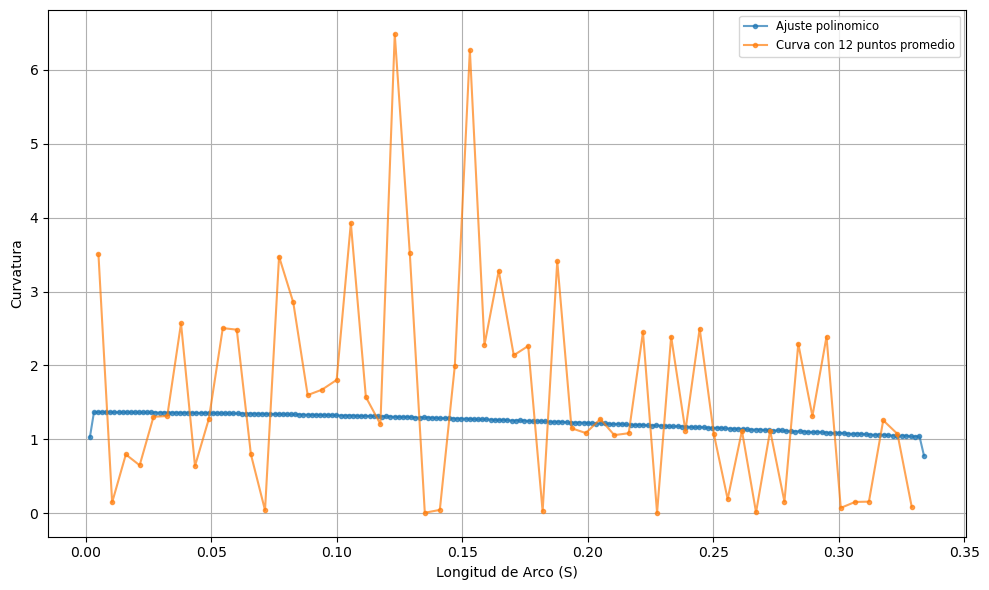

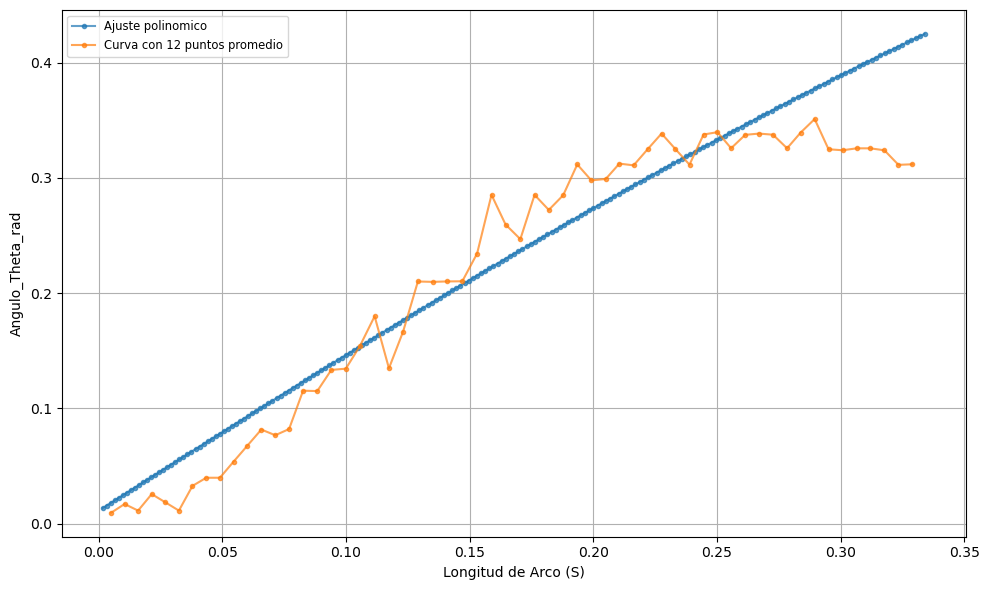

In [11]:
logging.info("Generando gráficos K vs S para cada valor de N...")
cols = ["Curvatura", "Angulo_Theta_rad"]

file_list  = ["results/20250428_h15_q2/20250428_h15_q2_ordered_avg12_Points_interpolated_Curvatura.csv", "results/20250428_h15_q2/20250428_h15_q2_ordered_avg12_Curvatura.csv"]
file_label = ["Ajuste polinomico" , "Curva con 12 puntos promedio"]
n_value = 12



for colY in cols:
    fig, ax = plt.subplots(figsize=(10, 6)) # Tamaño del gráfico
    logging.info(f"Procesando N = {n_value}...")
    # Crear una nueva figura y ejes para cada N

    plot_successful_count = 0

    for file_path, label in zip(file_list, file_label):
        try:
            # Leer el archivo CSV usando pandas
            df = pd.read_csv(file_path, delimiter="\t")

            # Verificar que las columnas 'S' y 'K' existen
            if 'LongitudArco_S' not in df.columns or colY not in df.columns:
                logging.warning(f"El archivo '{file_path}' no contiene las columnas 'S' y/o 'K'. Saltando.")
                continue # Pasar al siguiente archivo

            # Extraer las columnas S y K
            s_data = df['LongitudArco_S']
            k_data = df[colY]

            # Graficar K vs S para este archivo en los ejes actuales
            # Usar alpha para transparencia si hay muchas líneas superpuestas
            ax.plot(s_data, k_data, marker='.', linestyle='-', alpha=0.7, label=label)
            plot_successful_count += 1

        except pd.errors.EmptyDataError:
            logging.warning(f"El archivo CSV '{file_path}' está vacío. Saltando.")
        except pd.errors.ParserError:
             logging.warning(f"Error al parsear el archivo CSV '{file_path}'. Puede estar corrupto. Saltando.")
        except Exception as e:
            logging.error(f"Error inesperado al procesar el archivo '{file_path}': {e}")

    # Configurar el gráfico para el N actual
    if plot_successful_count > 0: # Solo mostrar gráfico si se pudo plotear algo
        ax.set_xlabel('Longitud de Arco (S)')
        ax.set_ylabel(colY)
        ax.grid(True) # Añadir rejilla para facilitar la lectura

        # Añadir leyenda (puede ser grande si hay muchos archivos)
        # Considerar mostrarla solo si hay pocos archivos o ajustar su posición
        if len(file_list) <= 10: # Mostrar leyenda solo si no hay demasiados archivos
             ax.legend(fontsize='small')
        else:
             logging.info(f"  (Leyenda omitida para N={n_value} debido a demasiados archivos: {len(file_list)})")


        # Ajustar el layout para evitar solapamientos de etiquetas
        plt.tight_layout()
        # Mostrar el gráfico (se mostrarán uno tras otro)
        # plt.show()
    else:
        logging.warning(f"No se pudieron graficar datos para N = {n_value}.")
        plt.close(fig) # Cerrar la figura vacía

logging.info("Proceso completado.")